# **Медицинская диагностика.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from zipfile import ZipFile
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Инсульт является одной из ведущих причин смертей. Поэтому важной задачей является определение правильного прогноза по набору признаков. Необходимо построить модель, которая будет осуществляьб этот прогноз. 


Загрузим данные о пациентах (набор данных берется из репозитория данных Kaggle [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv) )

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

Таблица содержит данные о 5110 пациентах. Для каждого известны 12 атрибутов.
Данные содержат следующую информацию о пациентах: 

*   идентификатор
*   пол
*   возраст
*   данные об артериальной гипертензии
*   информацию о наличии сердечных заболеваний (порог сердца)
*   семейное положение
*   тип работы
*   тип проживания
*   средний уровень глюкозы в крови
*   индекс массы тела
*   статус курения
*   наличие инсульта

Посмотрим на размеры таблицы, а затем на содержание(выведем начало и конец таблицы)

In [3]:
data.shape

(5110, 12)

In [4]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


* 1) id: уникальный идентификатор
* 2) gender - пол: Male, Female или Other
* 3) age: возраст пациента
* 4) hypertension - артериальная гипертензия: 0 - если у пациента нет гипертонии, 1 - если у пациента гипертония
* 5) heart_disease: 0 - если у пациента нет сердечных заболеваний, 1 - если у пациента сердечное заболевание
* 6) ever_married: No или Yes
* 7) work_type: «children», «Govt_jov», «Never_worked», «Private» или «Self-employed»
* 8)Residence_type - Тип проживания: Rural или Urban 
* 9) avg_gluosis_level: средний уровень глюкозы в крови
* 10) bmi: индекс массы тела
* 11) Smoking_status: formerly smoked, never smoked,  smokes или Unknown
* 12) stroke - инсульт: 1 - если у пациента был инсульт, 0 - если нет

В данном наборе данных есть как числовые, так и категориальные переменные.
Целевая переменная - "stroke". Она кодируется как:

*   1 - есть инсульт
*   0 - нет инсульта

Требуется предсказать наличие у человека инсульта по его входным параметрам.

**Недостающие данные**

Посмотрим, сколько пропущенных значений в каждом столбце:

In [5]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Видим, что только в столбце bmi присутствуют пропущенные значения (NaN) - 201 нулевых значений. Пропущенные значения - числовые переменные.


Для заполнения используем функцию SimpleImputer. Заполним пропущенные значения медианой и преобразуем данные. Затем выведем информацию еще раз и увидим, что пропущенных значений теперь нет.

In [6]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
data.bmi = imputer.fit_transform(data.bmi.values.reshape(-1,1))

data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Описательная статистика и визуализация + выбросы(outliers)**

Сначала посмотрим на уникальность наших данных

In [7]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Нам не нужен столбец id. Столбец состоит из уникальных данных, которые в нашей задаче для прогнозирования инсульта не нужны. Поэтому можно его убрать:

In [8]:
data.drop('id', axis=1, inplace=True)
data.columns
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Проверим наличие повторяющихся данных. Ниже видно, что повторений нет:

In [9]:
data.duplicated().sum()

0

У нас 2 признака, разделим их, чтобы было удобнее анализировать данные:

In [10]:
numerical= data.select_dtypes('number').columns
categorical = data.select_dtypes('object').columns

In [11]:
print(numerical, categorical)

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object') Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


*Числовые признаки*

Посмотрим сначала на числовые признаки.

In [12]:
data[numerical].head().T

,0,1,2,3,4
age,67.00,61.00,80.00,49.00,79.00
hypertension,0.00,0.00,0.00,0.00,1.00
heart_disease,1.00,0.00,1.00,0.00,0.00
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.60,28.10,32.50,34.40,24.00
stroke,1.00,1.00,1.00,1.00,1.00


In [13]:
data[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,5110.0,28.862035,7.699562,10.30,23.800,28.100,32.80,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


Из таблицы, например, видно, что пропущенных значений нет ( так как мы уже заполнили их медианой), присутствует маленький возраст, который необходимо удалить.

Присутствует маленький возраст, который надо удалить. На диаграмме рассеивания видны эти выбросы.

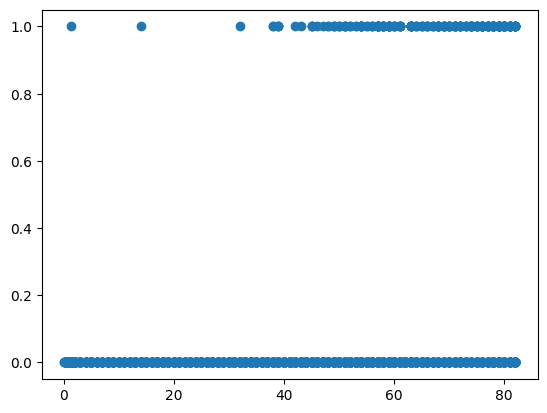

In [14]:
plt.scatter(data['age'], data['stroke'])
pass

In [15]:
data.age.sort_values()

3295     0.08
1614     0.08
3618     0.16
4021     0.16
3968     0.16
        ...  
4590    82.00
4094    82.00
2341    82.00
4716    82.00
187     82.00
Name: age, Length: 5110, dtype: float64

В столбце возраста содержатся бессмысленные значения. Мы должны убрать тех, у кого был инсульт, но возраст меньше 10 (14 и 1.32). Мы видели эти выбросы и на диаграмме рассеивания выше.


In [16]:
data[data['stroke']==1]['age'].nsmallest(10)

162     1.32
245    14.00
182    32.00
118    38.00
133    38.00
49     39.00
210    39.00
228    39.00
31     42.00
79     43.00
Name: age, dtype: float64

In [17]:
data = data.drop(index=162)
data = data.drop(index=245)

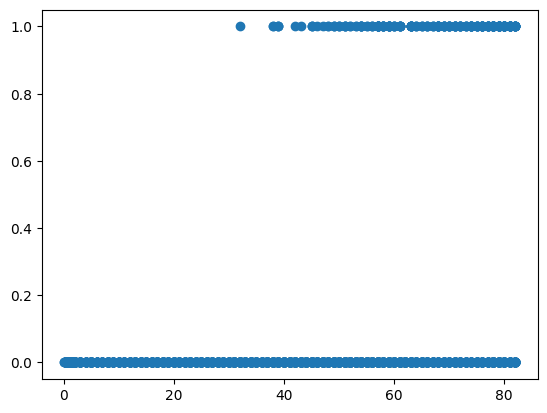

In [18]:
plt.scatter(data['age'], data['stroke'])

Построим бокс-диаграмму:

<AxesSubplot: xlabel='stroke', ylabel='age'>

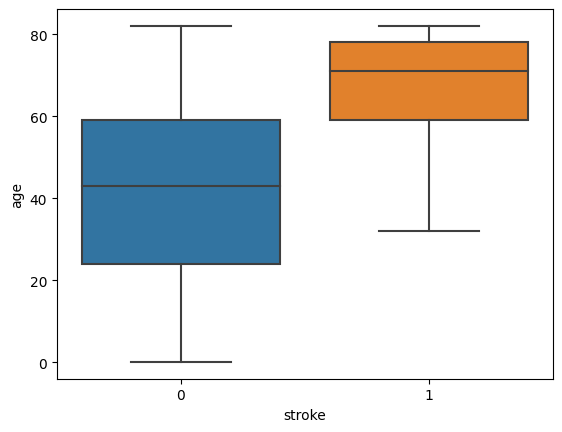

In [19]:
sns.boxplot(x="stroke", y="age", data=data)

От выбросов мы уже избавились. Можно сделать вывод по этой диаграмме, что люди старше 60 склонны к инсульту 

2. hypertension


Гипертония влияет на инсульт, поэтому она может оказаться важным признаком для вашей задачи.

In [20]:
data.hypertension.value_counts()

0    4610
1     498
Name: hypertension, dtype: int64

Видим, что людей с гипертонией намного меньше. Посмотрим на зависимость инсульта от гипертонии

<AxesSubplot: xlabel='hypertension', ylabel='count'>

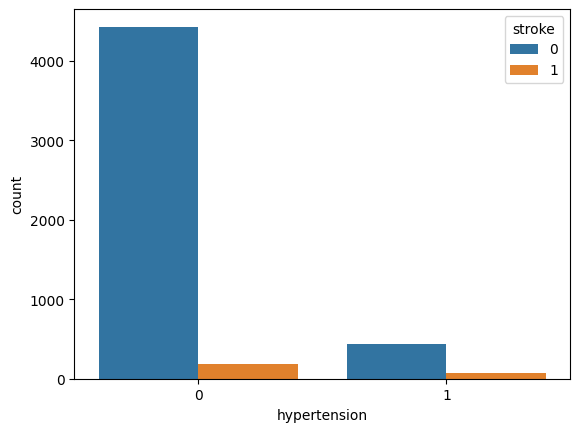

In [21]:
sns.countplot(data=data,x='hypertension',hue='stroke')

Можно заметить, что да, гипертония вызывает инсульт, но , к сожалению, данных слишком мало, чтобы увидеть явную зависимоть. Но можно сделать вывод, что у людей с гипертонией инсульт встречается чаще, то есть у людей с гипертонией риск инсульта выше.

3. heart_disease

Очевидно, что данный признак тоже должен влиять на инсульт.

In [22]:
data.heart_disease.value_counts()

0    4832
1     276
Name: heart_disease, dtype: int64

Опять видим, что людей с сердечными заболеваниями намного меньше.

<AxesSubplot: xlabel='heart_disease', ylabel='count'>

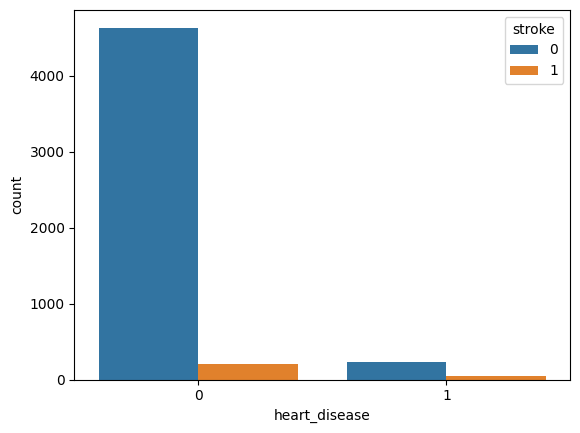

In [23]:
sns.countplot(data=data,x='heart_disease',hue='stroke')

Можно сделать такой же вывод, как и с гипертонией. То есть риск инсульта  при наличии сердечных заболеваний выше.

Гипертония и сердечные заболевания сами по себе должны влиять на инсульт, но из-за несбалансированного набора данных трудно увидеть явную зависимость.

4. avg_glucose_level

In [24]:
data.avg_glucose_level.value_counts()

93.88     6
91.85     5
83.16     5
73.00     5
72.49     5
         ..
111.93    1
94.40     1
95.57     1
66.29     1
85.28     1
Name: avg_glucose_level, Length: 3978, dtype: int64

Посмотрим на зависимость уровня глюкозы и инсульта:

<AxesSubplot: xlabel='avg_glucose_level', ylabel='count'>

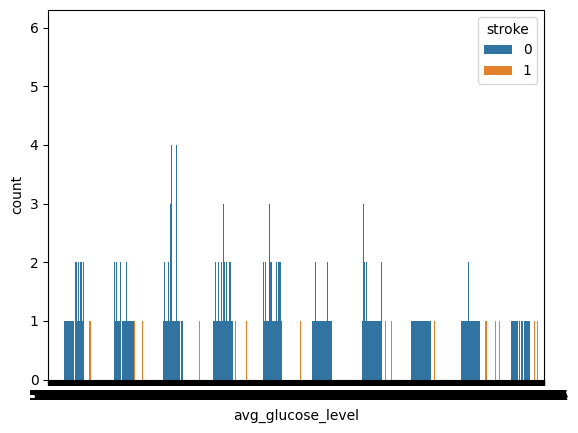

In [25]:
sns.countplot(data=data,x='avg_glucose_level',hue='stroke')

<AxesSubplot: xlabel='stroke', ylabel='avg_glucose_level'>

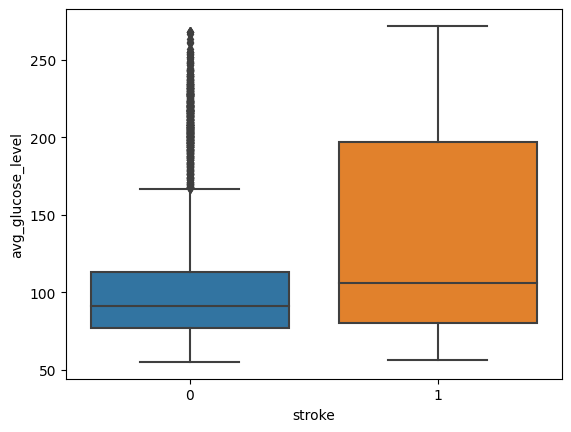

In [26]:
sns.boxplot(x="stroke", y="avg_glucose_level", data=data)

Видим, что присутствуют выбросы. Можно сделать вывод, что у людей с инсультом уровень глюкозы > 100.

5. bmi

In [27]:
data.bmi.value_counts()

28.1    229
28.7     41
28.4     38
26.7     37
26.1     37
       ... 
48.7      1
49.2      1
51.0      1
49.4      1
14.9      1
Name: bmi, Length: 418, dtype: int64

<AxesSubplot: xlabel='bmi', ylabel='count'>

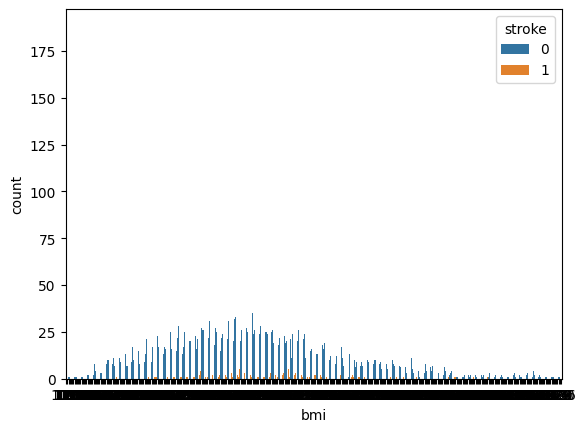

In [28]:
sns.countplot(data=data,x='bmi',hue='stroke')

<AxesSubplot: xlabel='stroke', ylabel='bmi'>

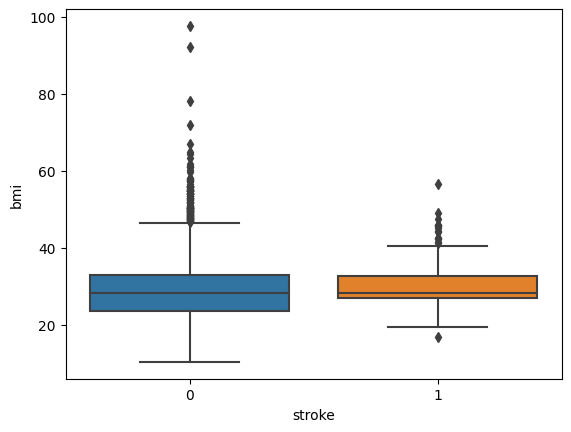

In [29]:
sns.boxplot(x="stroke", y="bmi", data=data)

По диаграмме видны выбросы.

*Категориальные признаки*

In [30]:
data[categorical].head().T

,0,1,2,3,4
gender,Male,Female,Male,Female,Female
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
smoking_status,formerly smoked,never smoked,never smoked,smokes,never smoked


In [31]:
data[categorical].describe().T

,count,unique,top,freq
gender,5108,3,Female,2992
ever_married,5108,2,Yes,3353
work_type,5108,5,Private,2925
Residence_type,5108,2,Urban,2595
smoking_status,5108,4,never smoked,1892


1. gender

In [32]:
data.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [33]:
data['gender'].value_counts()

Female    2992
Male      2115
Other        1
Name: gender, dtype: int64

Присутствует значение "Other", оно единственное. Будем считать его некорректным. Можно просто удалить это значени ил присвоить ему значение из двух других. Присвоим ему наимолее распространенное значение - Female

In [34]:
data['gender'] = data['gender'].replace('Other', 'Female')

In [35]:
data['gender'].value_counts()

Female    2993
Male      2115
Name: gender, dtype: int64

<AxesSubplot: xlabel='gender', ylabel='count'>

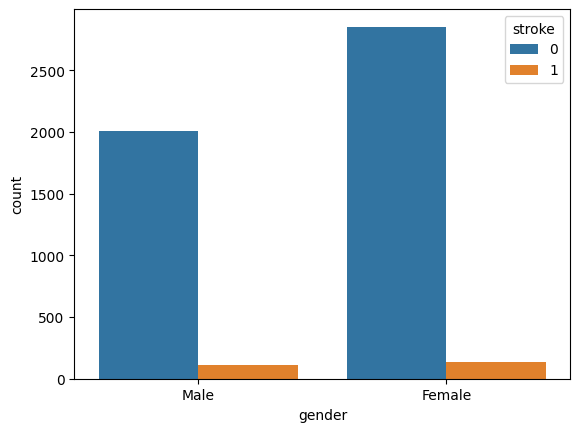

In [36]:
sns.countplot(data=data,x='gender',hue='stroke')

Видим, что частота встречаемости инсульта практически никак не зависит от пола.

2. ever_married

In [37]:
data['ever_married'].value_counts()

Yes    3353
No     1755
Name: ever_married, dtype: int64

<AxesSubplot: xlabel='ever_married', ylabel='count'>

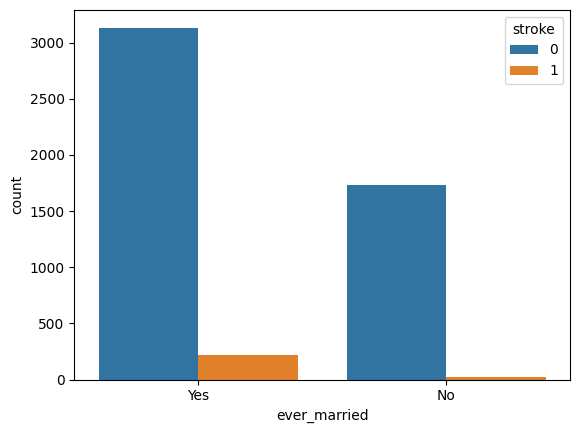

In [38]:
sns.countplot(data=data,x='ever_married',hue='stroke')

Вероятность инсульта выше у тех, кто когда-либо был женат.

3. work type

In [39]:
data.work_type.value_counts()

Private          2925
Self-employed     819
children          685
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [40]:
data['work_type'].describe()

count        5108
unique          5
top       Private
freq         2925
Name: work_type, dtype: object

<AxesSubplot: xlabel='work_type', ylabel='count'>

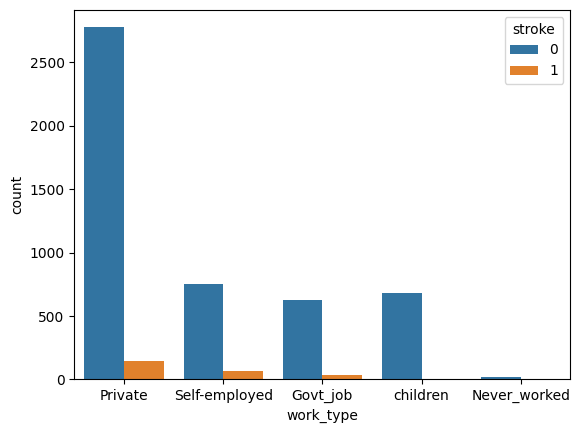

In [41]:
sns.countplot(data=data,x='work_type',hue='stroke')

Вполне логичные результаты: те, кто работает/работал риск инсульта выше, а у тех, кто не работает он нулевой.

4. Residence_type

In [42]:
data.Residence_type.value_counts()

Urban    2595
Rural    2513
Name: Residence_type, dtype: int64

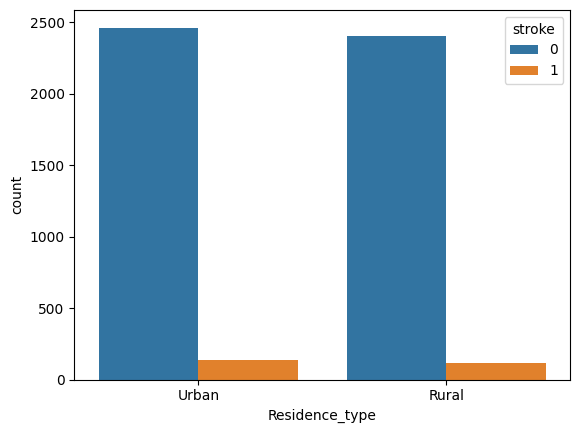

In [43]:
sns.countplot(data=data,x='Residence_type',hue='stroke')
pass

Вывод: нет никакой зависимости.

5. smoking status

In [44]:
data.smoking_status.value_counts()

never smoked       1892
Unknown            1542
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [45]:
data['smoking_status'].describe()

count             5108
unique               4
top       never smoked
freq              1892
Name: smoking_status, dtype: object

<AxesSubplot: xlabel='smoking_status', ylabel='count'>

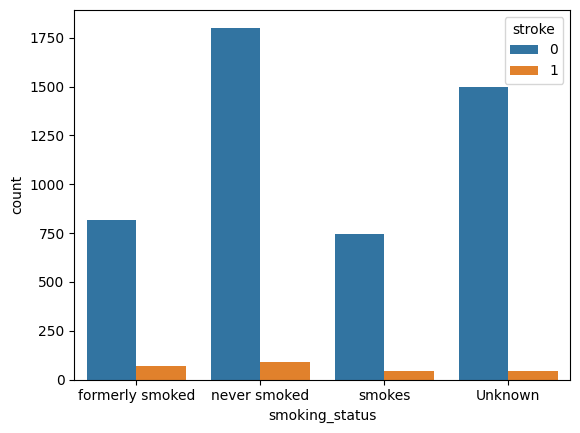

In [46]:
sns.countplot(data=data,x='smoking_status',hue='stroke')

Те, кто курит/курил имеют более высокую вероятность инсульта.

**Корреляция:**

C:\Users\User\AppData\Local\Temp\ipykernel_21300\3185859463.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap = 'coolwarm', annot=True, linewidths=3, linecolor='black')


<AxesSubplot: >

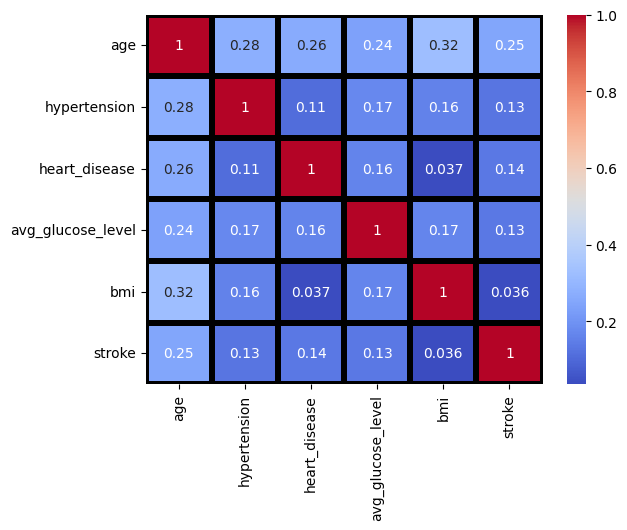

In [47]:
sns.heatmap(data.corr(), cmap = 'coolwarm', annot=True, linewidths=3, linecolor='black')

Наибольшую корреляцию составляют возраст и гипертония, индекс массы тела и возраст. А вот коэффициент между индексом массы тела и сердечными заболеваниями очень маленький. Самый маленький коэффициент - между инсультом и индексом массы тела.

**Целевая переменная**

In [48]:
data.stroke.value_counts()

0    4861
1     247
Name: stroke, dtype: int64

In [49]:
data.stroke.value_counts(normalize=True)*100

0    95.164448
1     4.835552
Name: stroke, dtype: float64

Почти у 95% экземпляров нашей целевой переменной нет инсульта(4861 человек). У 5% есть инсульт(249 человек).

Можно сделать вывод, что мы имеем дело с несбалансированными данными. 

In [50]:
data['stroke'].describe()

count    5108.000000
mean        0.048356
std         0.214537
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

Для наглядности несбалансированности данных, построим диаграмму:

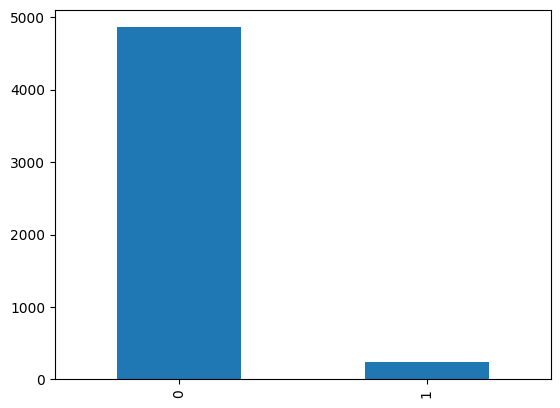

In [51]:
data['stroke'].value_counts().plot(kind = 'bar');

**Графики зависимостей между каждой парой признаков**

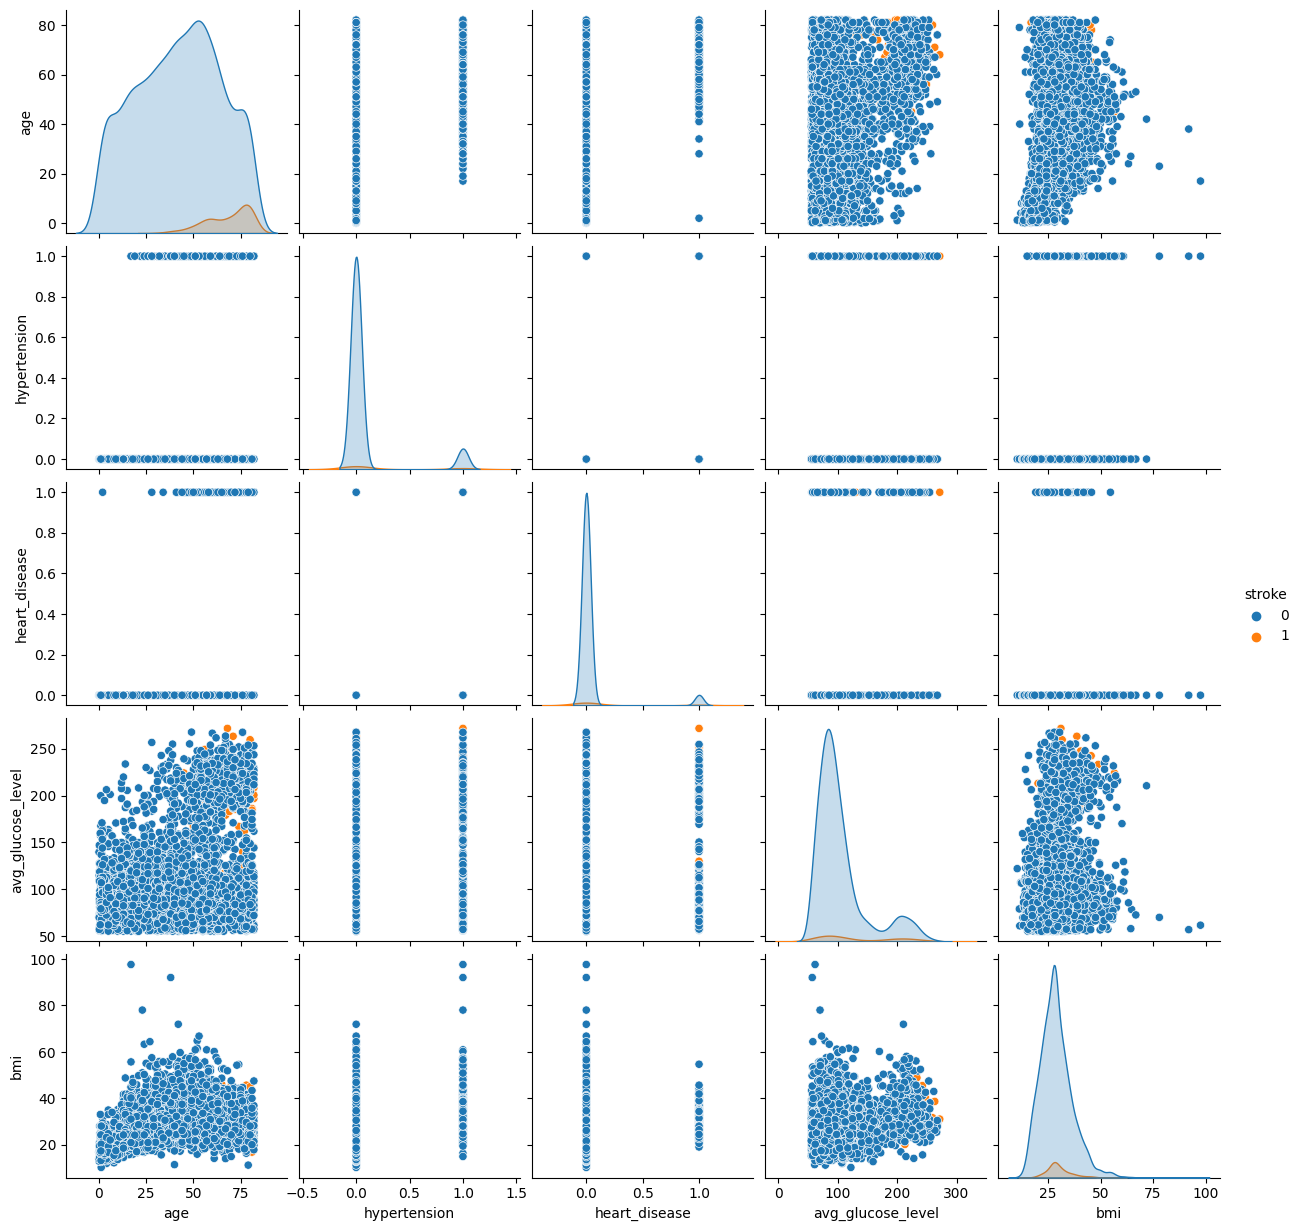

In [52]:
sns.pairplot(data,hue='stroke')

**Обработка категориальных признаков**

One-Hot Encoding  - кодирует значения как двоичный векторный массив.

Выполняем бинаризацию с помощью функции get_dummies:

In [53]:
data = pd.get_dummies(data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',], drop_first=True)

In [54]:
data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.1,1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,0,0,1,0,1,0,0,1,0,1,0
5106,81.0,0,0,125.20,40.0,0,0,1,0,0,1,0,1,0,1,0
5107,35.0,0,0,82.99,30.6,0,0,1,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.6,0,1,1,0,1,0,0,0,1,0,0


**Предварительная обработка данных**

In [55]:
X = data.drop('stroke',axis=1)
y = data['stroke']

In [56]:
X

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,0,1,0,1,0,0,1,0,1,0
5106,81.0,0,0,125.20,40.0,0,1,0,0,1,0,1,0,1,0
5107,35.0,0,0,82.99,30.6,0,1,0,0,1,0,0,0,1,0
5108,51.0,0,0,166.29,25.6,1,1,0,1,0,0,0,1,0,0


In [57]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5108, dtype: int64

**Деление выборки на обучающую и тестовую**

Используем stratify, чтобы пропорция значений в выборке была как в параметре y

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(X_train.shape[0], X_test.shape[0])

3575 1533


**Нормализация**

In [59]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**KNeighborsClassifier**

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import accuracy_score, log_loss


In [61]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
error_rate_train = []
error_rate_test = []
neighbors = []

In [62]:
for i in range(2,90, 4):
    model = KNeighborsClassifier(algorithm='auto', n_neighbors=i, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    
    neighbors.append(i)
    
    accuracy_train.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    accuracy_test.append(accuracy_score(y_test, model.predict(X_test_scaled)))

    error_rate_train.append(1-accuracy_score(y_train, model.predict(X_train_scaled)))
    error_rate_test.append(1-accuracy_score(y_test, model.predict(X_test_scaled)))

    loss_train.append(log_loss(y_train, model.predict_proba(X_train_scaled)))
    loss_test.append(log_loss(y_test, model.predict_proba(X_test_scaled)))


Text(0, 0.5, 'Точность')

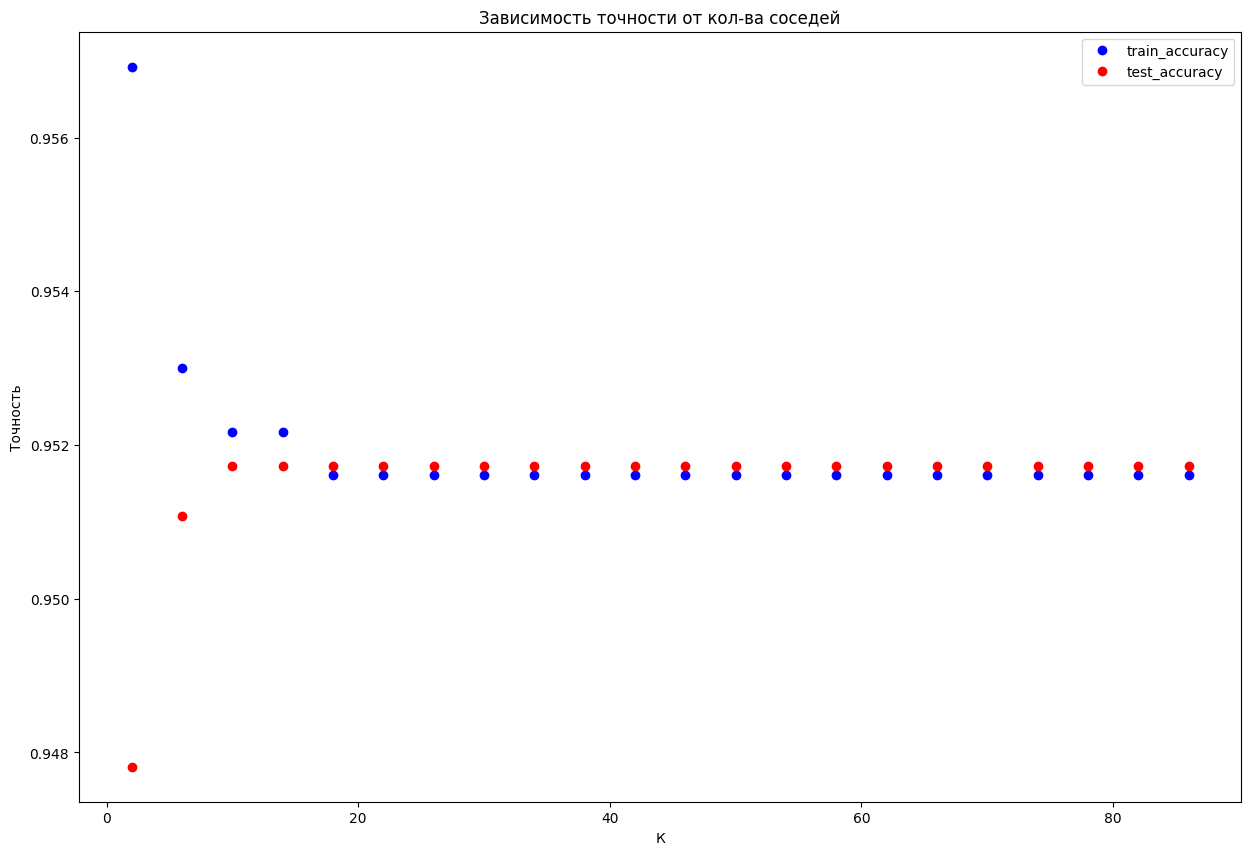

In [63]:
plt.figure(figsize=(15,10))

plt.plot(neighbors, accuracy_train, 'bo', neighbors, accuracy_test, 'ro')
plt.legend(['train_accuracy', 'test_accuracy'])
plt.title('Зависимость точности от кол-ва соседей')
plt.xlabel('К')
plt.ylabel('Точность')

При k = 10 точность на тестовой выборке достигает максимального значения и перестает изменяться, значение колеблется в районе чуть ниже 95.2%

Text(0, 0.5, 'Кросс-энтропия')

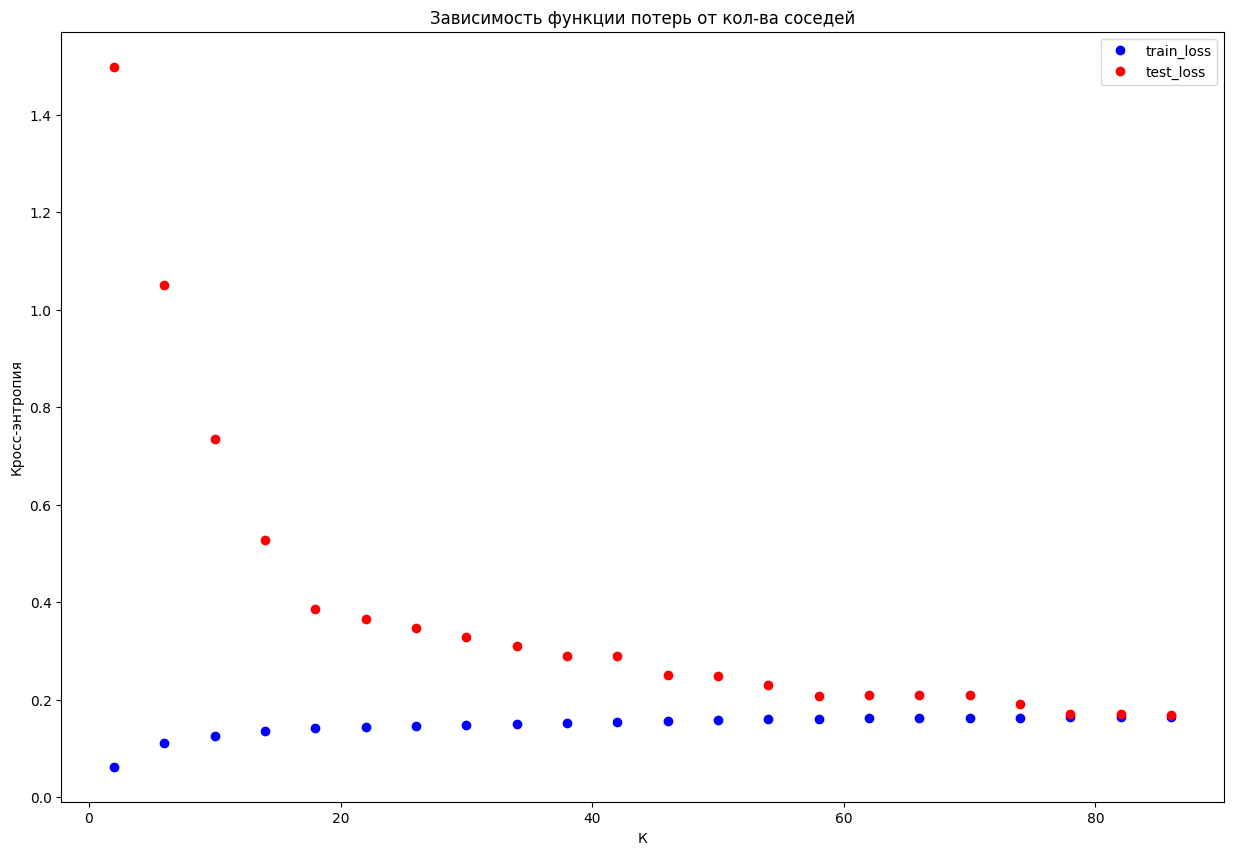

In [64]:
plt.figure(figsize=(15,10))

plt.plot(neighbors, loss_train, 'bo', neighbors, loss_test, 'ro')
plt.legend(['train_loss', 'test_loss'])
plt.title('Зависимость функции потерь от кол-ва соседей')
plt.xlabel('К')
plt.ylabel('Кросс-энтропия')

Функции потерь по выборкам приближается к значению 0.19

### Обучение полносвязной нейронной сети

In [66]:
from sklearn.neural_network import MLPClassifier

In [67]:
mlp_model = MLPClassifier(
    hidden_layer_sizes = (100,),
    solver = 'lbfgs', 
    activation = 'relu',
    random_state = 25,
    max_iter = 1500
)

In [ ]:
mlp_model.fit(X_train_scaled, y_train)

#### Проверка качества классификатора

In [69]:
y_train_pred = mlp_model.predict(X_train_scaled)
y_test_pred = mlp_model.predict(X_test)

print(f'Train = {accuracy_score(y_train, y_train_pred)}')
print(f'Test = {accuracy_score(y_test, y_test_pred)}')

Train = 0.9924475524475525
Test = 0.9517286366601435


d:\c++\NNSU\M1\ml\MachineLearningCourse\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


#### Гиперпараметры

Подберем оптимальное значение параметра регуляризации alpha. В качестве solver возьмем оптимизатор из семейства квазиньютоновских методов - lbfgs. Так как у нас небольшой набор данных, то он может сходиться быстрее, чем популярный adam. В качестве функции активации выберем Relu. А в качетве метрики оценки классификатора - accuracy_score.


In [ ]:
from sklearn.metrics import accuracy_score

alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:

    mlp_model = MLPClassifier(
        alpha = alpha, 
        hidden_layer_sizes = (100,), 
        solver = 'lbfgs', 
        activation = 'relu', 
        max_iter=1500, 
        random_state = 25
    )
    
    mlp_model.fit(X_train_scaled, y_train)

    y_train_pred = mlp_model.predict(X_train_scaled)
    y_test_pred = mlp_model.predict(X_test_scaled)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

#### График зависимости ошибки на тренировочной и тестовых выборках от параметра регуляризации

Минимальное значение ошибки
Train: Min error = 0.008111888111888113
alpha = 0.005623413251903491
Test: Min error = 0.04827136333985649
alpha = 3.1622776601683795


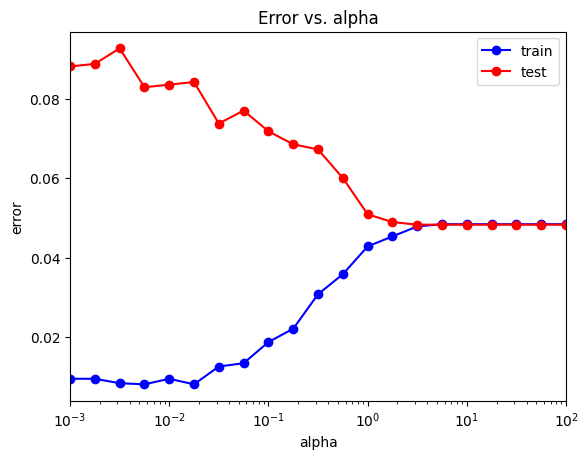

In [72]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

print("Минимальное значение ошибки")
print(f'Train: Min error = {np.min(train_err)}')
print(f'alpha = {alpha_arr[np.argmin(train_err)]}')

print(f'Test: Min error = {np.min(test_err)}')
print(f'alpha = {alpha_arr[np.argmin(test_err)]}')


#### График зависимости accuracy на тренировочной и тестовых выборках от параметра регуляризации

Train: Max accuracy = 0.9918881118881119
alpha = 0.005623413251903491
Test: Max accuracy = 0.9517286366601435
alpha = 3.1622776601683795


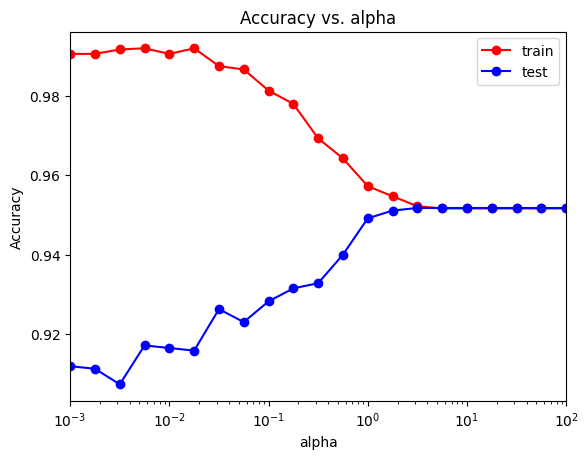

In [74]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

print(f'Train: Max accuracy = {np.max(train_acc)}')
print(f'alpha = {alpha_arr[np.argmax(train_acc)]}')

print(f'Test: Max accuracy = {np.max(test_acc)}')
print(f'alpha = {alpha_arr[np.argmax(test_acc)]}')

Из графика можно заметить, что при alpha < 2 (+-) наблюдается переобучение. А начиная с alpha_opt точность на обучающей и тестовой выборках совпадает. Это оптимальное значение для параметра регуляризации.

**Оптимальное значение alpha:**

In [75]:
min_test_err = np.min(test_err)
alpha_opt = alpha_arr[test_err == min_test_err][0]
print(alpha_opt)

3.1622776601683795


Результаты работы классификатора при найденном оптимальном значении регуляризации

In [77]:
mlp_model = MLPClassifier(
    alpha = alpha_opt, 
    hidden_layer_sizes = (100,),
    solver = 'lbfgs', 
    activation = 'relu', 
    random_state = 25, 
    max_iter = 1500
)

mlp_model.fit(X_train_scaled, y_train)

y_train_pred = mlp_model.predict(X_train_scaled)
y_test_pred = mlp_model.predict(X_test_scaled)

print(f'Train accuracy = {accuracy_score(y_train, y_train_pred)}')
print(f'Test accuracy = {accuracy_score(y_test, y_test_pred)}')

Train accuracy = 0.9521678321678322
Test accuracy = 0.9517286366601435


Построим матрицу рассогласования

d:\c++\NNSU\M1\ml\MachineLearningCourse\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


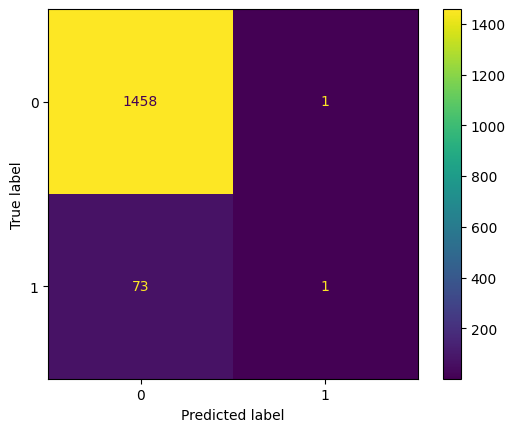

In [84]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(mlp_model, X_test_scaled, y_test) 

В 73 случаях модель ошиблась - не смогла предсказать инфаркт

## Подбор числа нейронов в односвязной сети

In [ ]:
count_arr = (np.linspace(1, 100, 80)).astype(int)

test_err = []
train_err = []
train_acc = []
test_acc = []

for i in count_arr:
    mlp_model = MLPClassifier(
        alpha = alpha_opt,
        hidden_layer_sizes = (i,), 
        solver = 'lbfgs', 
        activation = 'relu', 
        max_iter=1500, 
        random_state = 25
    )
    
    mlp_model.fit(X_train_scaled, y_train)

    y_train_pred = mlp_model.predict(X_train_scaled)
    y_test_pred = mlp_model.predict(X_test_scaled)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Train: Min error = 0.04727272727272727
Number of neurons = 63
Test: Min error = 0.046966731898238745
Number of neurons = 63


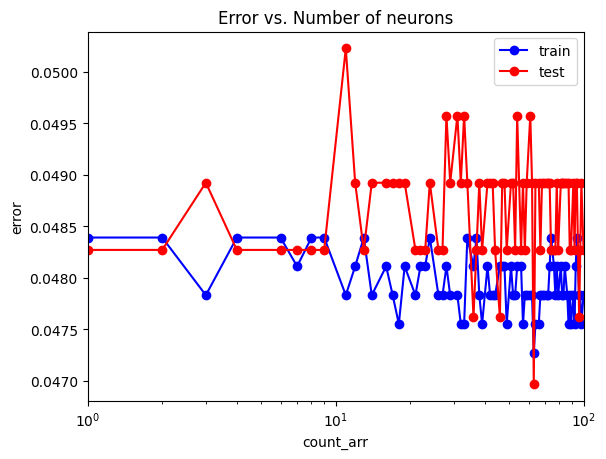

In [87]:
plt.semilogx(count_arr, train_err, 'b-o', label = 'train')
plt.semilogx(count_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(count_arr), np.max(count_arr)])
plt.title('Error vs. Number of neurons')
plt.xlabel('count_arr')
plt.ylabel('error')
plt.legend()

print(f'Train: Min error = {np.min(train_err)}')
print(f'Number of neurons = {count_arr[np.argmin(train_err)]}')

print(f'Test: Min error = {np.min(test_err)}')
print(f'Number of neurons = {count_arr[np.argmin(test_err)]}')


### Таким образом, получаем оптимальное кол-во нейронов 63 при параметре регуляризации alpha = 3.1622